In [1]:
import healpy as hp
import numpy as np
import matplotlib.pyplot as plt
import pymaster as nmt
import pickle as pk
import sys
from lenspyx.utils import camb_clfile
sys.path.append('../../')

In [2]:
import libparam as method

usage: ipykernel_launcher.py [-h] [-ivt] [-ivp] [-dd] [-delens] [-cl] inifile
ipykernel_launcher.py: error: unrecognized arguments: -f
/global/homes/l/lonappan/.conda/envs/PC/lib/python3.6/site-packages/healpy/fitsfunc.py:369: UserWarning: If you are not specifying the input dtype and using the default np.float64 dtype of read_map(), please consider that it will change in a future version to None as to keep the same dtype of the input file: please explicitly set the dtype if it is important to you.
  "If you are not specifying the input dtype and using the default "


Simulation uses /project/projectdirs/litebird/simulations/S4BIRD/LiteBird/RS/Maps


/global/homes/l/lonappan/.conda/envs/PC/lib/python3.6/site-packages/healpy/fitsfunc.py:391: UserWarning: NSIDE = 2048
  warnings.warn("NSIDE = {0:d}".format(nside))
/global/homes/l/lonappan/.conda/envs/PC/lib/python3.6/site-packages/healpy/fitsfunc.py:400: UserWarning: ORDERING = RING in fits file
  warnings.warn("ORDERING = {0:s} in fits file".format(ordering))
/global/homes/l/lonappan/.conda/envs/PC/lib/python3.6/site-packages/healpy/fitsfunc.py:428: UserWarning: INDXSCHM = IMPLICIT
  warnings.warn("INDXSCHM = {0:s}".format(schm))


Delensing uses QE: p
Workspace intializing from /project/projectdirs/litebird/simulations/S4BIRD/LiteBird/RS/Pseudo/workspace/coupling_matrix.fits


Mean and STD of Bandpower:  28%|██▊       | 28/100 [00:00<00:00, 279.23simulation/s]

returning cache
Bandpower calculated


Mean and STD of Bandpower: 100%|██████████| 100/100 [00:00<00:00, 488.13simulation/s]

Fitting Delensed spectra
Likelihood: HL
['c_fid.pkl', 'cov_del_w_lb.pkl']


In [3]:
Q,U = method.delens_lib.get_delensed_field(66)

In [4]:
cl_len = camb_clfile('/project/projectdirs/litebird/simulations/S4BIRD/CAMB/s4bird_lensedCls.dat')
cl_unl = camb_clfile('/project/projectdirs/litebird/simulations/S4BIRD/CAMB/s4bird_lenspotentialCls.dat')
ini = '/project/projectdirs/litebird/simulations/S4BIRD/CAMB/CAMB.ini'

In [5]:
wk = nmt.NmtWorkspace()

In [6]:
mask = hp.read_map('/global/u2/l/lonappan/workspace/S4bird/Data/masks/litebird_512_apo_C1_10.fits.gz')

/global/homes/l/lonappan/.conda/envs/PC/lib/python3.6/site-packages/healpy/fitsfunc.py:391: UserWarning: NSIDE = 512
  warnings.warn("NSIDE = {0:d}".format(nside))


In [7]:
f2  = nmt.NmtField(mask, [hp.ud_grade(Q,512), hp.ud_grade(U,512)], purify_b=True)

In [8]:
b = nmt.NmtBin.from_nside_linear(512, 10)

In [9]:
wk.compute_coupling_matrix(f2, f2, b)

In [10]:
cw = nmt.NmtCovarianceWorkspace()

In [11]:
cw.compute_coupling_coefficients(f2, f2, f2, f2)

In [12]:
def compute_master(f_a, f_b, wsp):
    cl_coupled = nmt.compute_coupled_cell(f_a, f_b)
    cl_decoupled = wsp.decouple_cell(cl_coupled)
    return cl_decoupled

In [13]:
cl_22 = compute_master(f2,f2,wk)

In [14]:
n_ell = len(cl_22[0])

In [18]:
cl_EE = cl_22[0]
cl_BB = cl_22[3]

In [19]:
cl_ee = cl_len['ee'][:b.lmax+1]
cl_eb = 0*cl_ee
cl_bb = .85*cl_len['bb'][:b.lmax+1]


covar_22_22 = nmt.gaussian_covariance(cw, 2, 2, 2, 2,  # Spins of the 4 fields
                                      [cl_ee, cl_eb,
                                       cl_eb, cl_bb],  # EE, EB, BE, BB
                                      [cl_ee, cl_eb,
                                       cl_eb, cl_bb],  # EE, EB, BE, BB
                                      [cl_ee, cl_eb,
                                       cl_eb, cl_bb],  # EE, EB, BE, BB
                                      [cl_ee, cl_eb,
                                       cl_eb, cl_bb],  # EE, EB, BE, BB
                                      wk, wb=wk).reshape([n_ell, 4,
                                                            n_ell, 4])

ValueError: Input C_ls have a weird length

In [16]:
covar_BB_BB = covar_22_22[:, 3, :, 3]

In [17]:
pk.dump(covar_BB_BB,open('cov_del_w_lb.pkl','wb'))

In [18]:
#pk.dump(method.pseudocl_lib.get_delensed_cl(66)[3]-method.eff_lib.bias,open('c_fid_s4mask.pkl','wb'))

In [19]:
#pk.dump(method.eff_lib.get_stat,open('lb_s4plb_spectra.pkl','wb'))

In [20]:
#pk.dump(method.eff_lib.bias,open('lb_s4plb_bias.pkl','wb'))

In [23]:
#cov_old = pk.load(open('cov_del_r_s4.pkl','rb'))

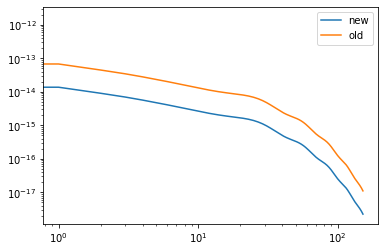

In [24]:
plt.loglog(np.diag(covar_BB_BB),label='new')
plt.loglog(np.diag(cov_old),label='old')
plt.legend()